In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('gutenberg')
nltk.download('punkt')

In [63]:
import pandas as pd
import nltk
import re
from nltk.corpus import gutenberg, stopwords

Stop_words = stopwords.words('english')
Sentences = gutenberg.sents('carroll-alice.txt')
TermsSentences = []

for terms in Sentences:
    terms = [w for w in terms if w not in Stop_words]
    terms = [w for w in terms if re.search(r'^[a-zA-Z]{2}', w) is not None]
    TermsSentences.append(terms)
df = pd.DataFrame(columns = ['sentence'])
#df.fillna(value="null", inplace=True)
#print(TermsSentences)
for values in TermsSentences:
    df = df.append({'sentence': values}, ignore_index=True)
df.head()
#df.to_csv("/Users/dzikipm1/Documents/alice.csv")

,sentence
0,"[Alice, Adventures, Wonderland, Lewis, Carroll]"
1,[CHAPTER]
2,"[Down, Rabbit, Hole]"
3,"[Alice, beginning, get, tired, sitting, sister..."
4,"[So, considering, mind, well, could, hot, day,..."


,sentence
0,"[Alice, Adventures, Wonderland, Lewis, Carroll]"
1,[CHAPTER]
2,"[Down, Rabbit, Hole]"
3,"[Alice, beginning, get, tired, sitting, sister..."
4,"[So, considering, mind, well, could, hot, day,..."


In the above cell, I cleaned and exported the text to csv to be analyzed in weka.  However, for some reason, Weka would not work for me.  I made sure all special characters were removed and it was correctly readinf the data, but received no results.

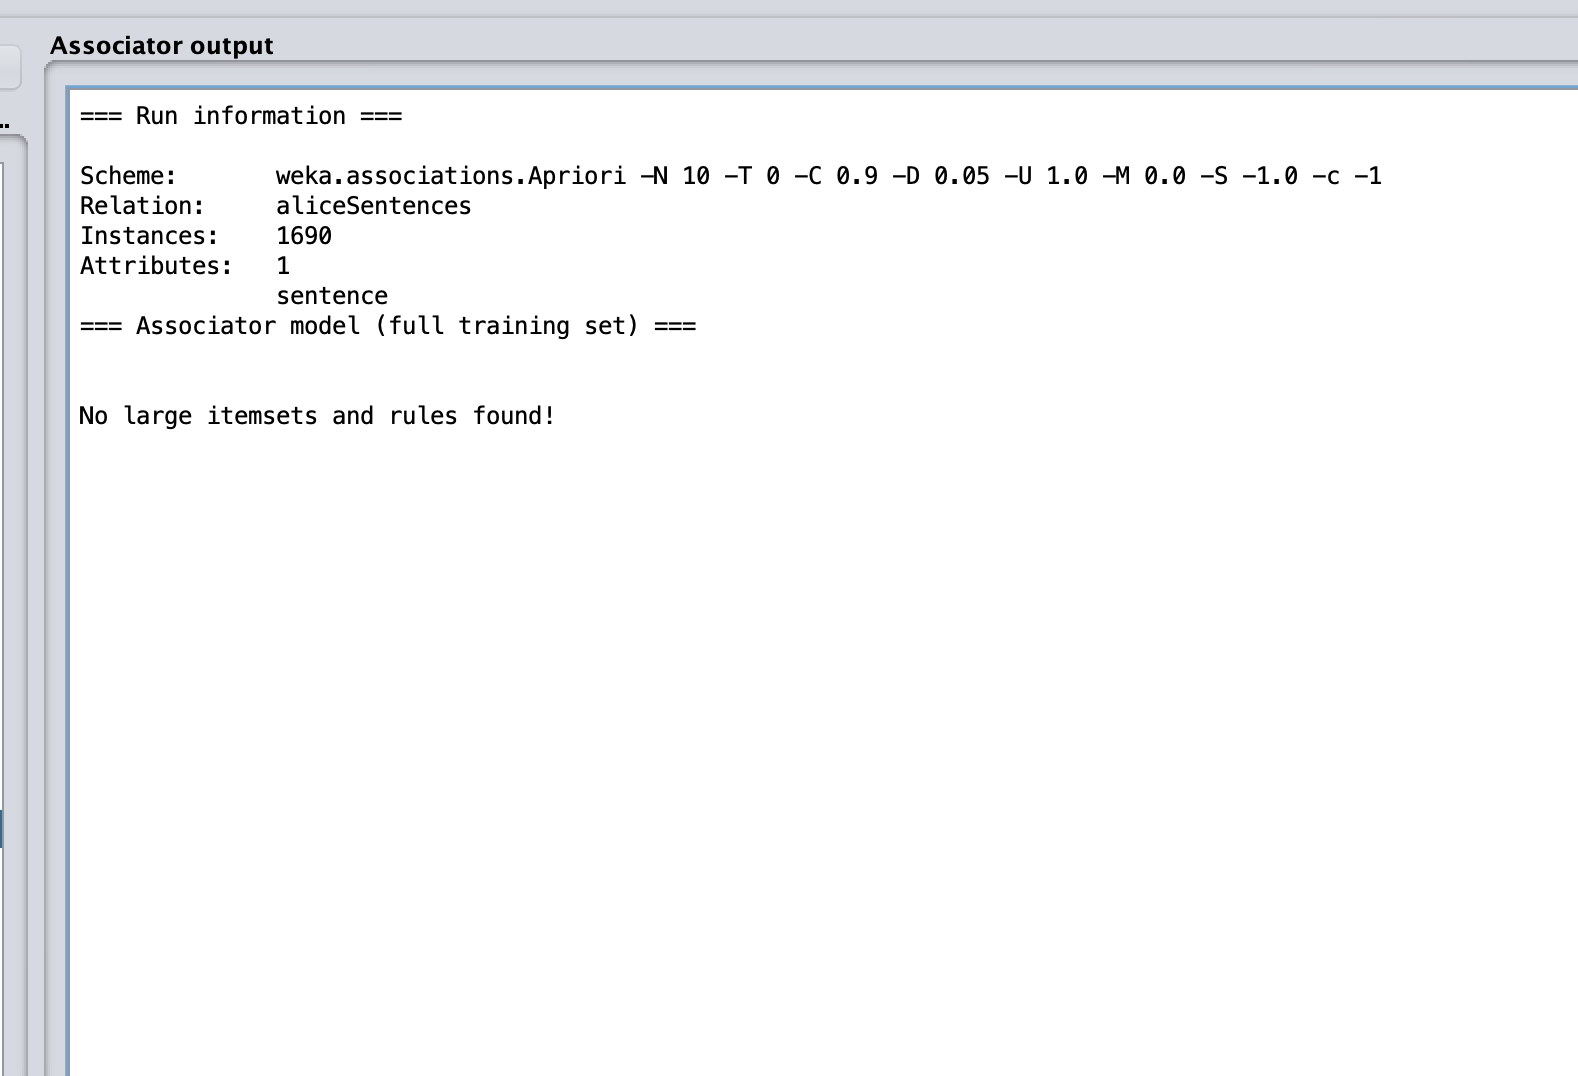

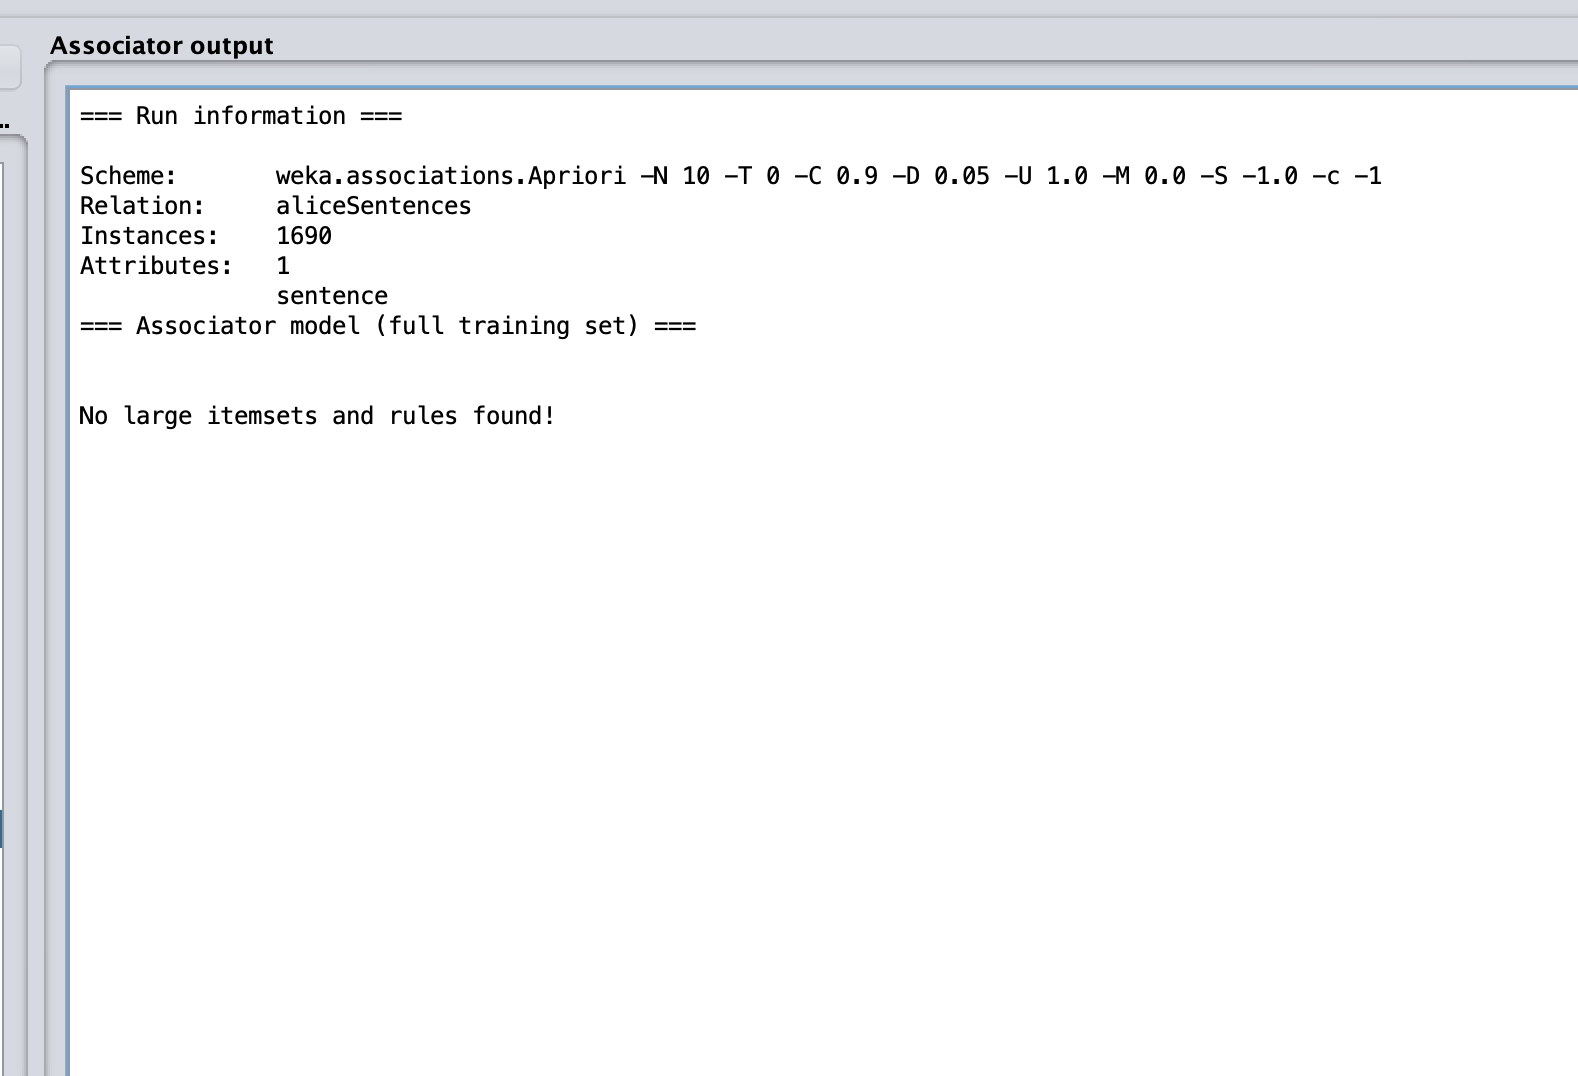

In [57]:
from IPython.display import Image
Image("/Users/dzikipm1/Documents/weka.png")

So I used NLTK to find patterns.

In [68]:
flat_list = []
for sublist in TermsSentences:
    for item in sublist:
        flat_list.append(item)

#text is now tokenized in one list

from nltk.probability import FreqDist
fdist = FreqDist(flat_list)
#10 most common words
print(fdist.most_common(10))


[('said', 456), ('Alice', 396), ('little', 125), ('The', 108), ('one', 94), ('know', 87), ('like', 84), ('went', 83), ('thought', 74), ('Queen', 74)]
[('said', 456), ('Alice', 396), ('little', 125), ('The', 108), ('one', 94), ('know', 87), ('like', 84), ('went', 83), ('thought', 74), ('Queen', 74)]


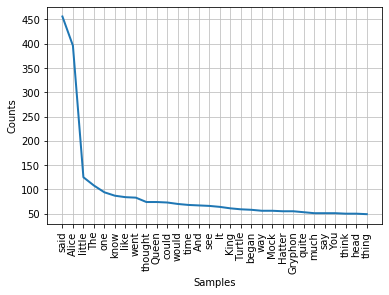

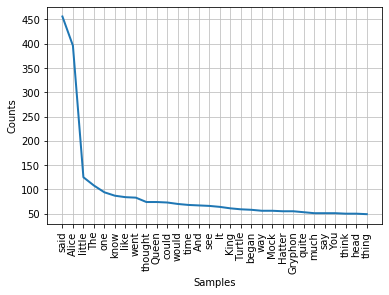

In [70]:
%matplotlib inline
import matplotlib.pyplot as plt
fdist.plot(30,cumulative=False)
plt.show()

In [8]:
def load_mnist(path, kind='train'):
    from numpy import fromfile, uint8
    import os
    import struct
    
    labels_path = os.path.join(path, '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, '%s-images-idx3-ubyte' % kind)
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = fromfile(lbpath, dtype=uint8)
        with open(images_path, 'rb') as imgpath:
            magic, num, rows, cols = struct.unpack(">IIII",imgpath.read(16))
            images = fromfile(imgpath, dtype=uint8).reshape(len(labels), 784)
            images = ((images / 255.) - .5) * 2
    #
    return images, labels

X_train, y_train = load_mnist('/Users/dzikipm1/Downloads', kind='train')
print(f'Rows= {X_train.shape[0]}, columns= {X_train.shape[1]}')

X_test, y_test = load_mnist('/Users/dzikipm1/Downloads', kind='t10k')
print(f'Rows= {X_test.shape[0]}, columns= {X_test.shape[1]}')

Rows= 60000, columns= 784
Rows= 10000, columns= 784
Rows= 60000, columns= 784
Rows= 10000, columns= 784


In [9]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix

from numpy import sum, float

import warnings
warnings.filterwarnings('ignore', 'Solver terminated early.*')

In [18]:
import numpy as np
from numpy import random, zeros, exp, clip, dot, log, sum, argmax, unique, arange, float
    
class NeuralNetMLP(object):
    def __init__(self, n_hidden=30, l2 = 0., epochs=100, eta=0.001, minibatch_size=1, seed=None):
        self.random = random.RandomState(seed)  # used to randomize weights
        self.n_hidden = n_hidden  # size of the hidden layer
        self.l2 = l2
        self.epochs = epochs  # number of iterations
        self.eta = eta  # learning rate
        self.minibatch_size = minibatch_size  # size of training batch - 1 would not work

    def onehot(y, n_classes):  # one hot encode the input class
        onehot = zeros((n_classes, y.shape[0]))
        for idx, val in enumerate(y.astype(int)):
            onehot[val, idx] = 1.0
        return onehot.T

    def sigmoid(z):  # Eq 1
        return 1.0 / (1.0 + exp(-clip(z, -250, 250)))

    def _forward(self, X):  # Eq 2
        z_h = dot(X, self.w_h) + self.b_h
        a_h = self.sigmoid(z_h)
        z_out = dot(a_h, self.w_out) + self.b_out
        a_out = self.sigmoid(z_out)
        return z_h, a_h, z_out, a_out

    def compute_cost(self, y_enc, output):  # Eq 4
        L2_term = (self.l2 * (np.sum(self.w_h **2.) + np.sum(self.w_out ** 2.)))
        term1 = -y_enc * (log(output))
        term2 = (1.0-y_enc) * log(1.0-output)
        cost = sum(term1 - term2) + L2_term
        return cost

    def predict(self, X):
        z_h, a_h, z_out, a_out = self._forward(X)
        y_pred = argmax(z_out, axis=1)
        return y_pred

    def fit(self, X_train, y_train, X_valid, y_valid):
        import sys
        n_output = unique(y_train).shape[0]  # number of class labels
        n_features = X_train.shape[1]
        self.b_h = np.zeros(self.n_hidden)
        self.b_out = np.zeros(n_output)
        self.w_out = self.random.normal(loc=0.0, scale=0.1, size=(self.n_hidden, n_output))
        self.w_h = self.random.normal(loc=0.0, scale=0.1, size=(n_features, self.n_hidden))
        y_train_enc = self.onehot(y_train, n_output)  # one-hot encode original y
        for i in range(self.epochs):
            indices = arange(X_train.shape[0])
            for start_idx in range(0, indices.shape[0] - self.minibatch_size + 1, self.minibatch_size):
                batch_idx = indices[start_idx:start_idx + self.minibatch_size]
                z_h, a_h, z_out, a_out = self._forward(X_train[batch_idx])
                sigmoid_derivative_h = a_h * (1.0-a_h)  # Eq 3
                delta_out = a_out - y_train_enc[batch_idx]  # Eq 5
                delta_h = (dot(delta_out, self.w_out.T) * sigmoid_derivative_h)  # Eq 6
                grad_w_h = dot(X_train[batch_idx].T, delta_h)  # Eq 8
                grad_b_h = np.sum(delta_h, axis = 0)
                grad_w_out = dot(a_h.T, delta_out)  # Eq 7
                grad_b_out = np.sum(delta_out, axis = 0)
                delta_w_h = (grad_w_h + self.l2*self.w_h)
                delta_b_h = grad_b_h
                self.w_h -= self.eta*grad_w_h  # Eq 9
                self.b_h -=self.eta*delta_b_h
                delta_w_out = (grad_w_out + self.l2*self.w_out)
                delta_b_out = grad_b_out
                self.w_out -= self.eta*delta_w_out  # Eq 9
                self.b_out -= self.eta * delta_b_out
                
            # Evaluation after each epoch during training
            z_h, a_h, z_out, a_out = self._forward(X_train)
            cost = self.compute_cost(self, y_enc=y_train_enc, output=a_out)
            y_train_pred = self.predict(X_train)  # monitoring training progress through reclassification
            y_valid_pred = self.predict(X_valid)  # monitoring training progress through validation
            train_acc = ((sum(y_train == y_train_pred)).astype(float) / X_train.shape[0])
            valid_acc = ((sum(y_valid == y_valid_pred)).astype(float) / X_valid.shape[0])
            sys.stderr.write('\r%d/%d | Cost: %.2f ' '| Train/Valid Acc.: %.2f%%/%.2f%% '%
                (i+1, self.epochs, cost, train_acc*100, valid_acc*100))
            sys.stderr.flush()
        #
        return self

In [19]:
# Define and fit the neural network
nn = NeuralNetMLP(n_hidden=20, l2 =0.01, epochs=300, eta=0.0005, minibatch_size=100, seed=1)

nn.fit(X_train=X_train[:55000], y_train=y_train[:55000], X_valid=X_train[55000:], y_valid=y_train[55000:]) ;

300/300 | Cost: 15952.82 | Train/Valid Acc.: 96.21%/95.32% 

In [20]:
y_pred = nn.predict(X_test)
test_acc = ((sum(y_test == y_pred)).astype(float) / y_test.shape[0])

print(f'Accuracy= {test_acc*100:.2f}%')
print(confusion_matrix(y_test,y_pred))

Accuracy= 94.34%
[[ 965    0    0    1    1    3    7    2    1    0]
 [   0 1106    3    1    1    0    5    2   17    0]
 [  10    3  957   14    3    2    8   10   24    1]
 [   3    2    8  942    0   24    5   10   12    4]
 [   0    0    2    1  948    1    5    2    5   18]
 [   8    2    2   37    5  793   11    5   22    7]
 [  11    5    2    1    4   13  916    1    5    0]
 [   0   10   14   10    3    1    0  975    3   12]
 [   6    5    4   16    8   10    5   11  905    4]
 [   7    6    0   17   29    6    1    9    7  927]]
Accuracy= 94.34%
[[ 965    0    0    1    1    3    7    2    1    0]
 [   0 1106    3    1    1    0    5    2   17    0]
 [  10    3  957   14    3    2    8   10   24    1]
 [   3    2    8  942    0   24    5   10   12    4]
 [   0    0    2    1  948    1    5    2    5   18]
 [   8    2    2   37    5  793   11    5   22    7]
 [  11    5    2    1    4   13  916    1    5    0]
 [   0   10   14   10    3    1    0  975    3   12]
 [   6    5